In [1]:
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install qiskit_algorithms
# %pip install datasets
# %pip install 'accelerate>=0.26.0'
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install transformers
# %pip install scikit-learn
# %pip install datasets
# %pip install kagglehub
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install qiskit_algorithms
# %pip install ipywidgets
# %pip install pylatexenc


In [2]:
import pickle
import gc 
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    AutoModelForCausalLM
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Sampler
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from joblib import Parallel, delayed
import kagglehub
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#### Dataset from https://www.kaggle.com/datasets/lizhecheng/llm-science-dataset

In [3]:
file_path = kagglehub.dataset_download("lizhecheng/llm-science-dataset")

# print(file_path)

#### DATA PREPARATION

##### Load the data

In [4]:
data = pd.read_csv(f"{file_path}/High Quality Dataset.csv")
print("Original Data:")
print(data.head())

Original Data:
   id                                             prompt  \
0   0  Which of the following statements accurately d...   
1   1  Which of the following is an accurate definiti...   
2   2  What is the significance of regularization in ...   
3   3  Which of the following statements accurately d...   
4   4  Which of the following statements accurately d...   

                                                   A  \
0  MOND is a theory that reduces the observed mis...   
1  Dynamic scaling refers to the evolution of sel...   
2  Regularizing the mass-energy of an electron wi...   
3  The angular spacing of features in the diffrac...   
4  The dimension of an object in a CW complex is ...   

                                                   B  \
0  MOND is a theory that increases the discrepanc...   
1  Dynamic scaling refers to the non-evolution of...   
2  Regularizing the mass-energy of an electron wi...   
3  The angular spacing of features in the diffrac...   
4  The 

##### Inspect mapping

In [30]:
data = data[:1000]

X = data['prompt'].values[300:]
y = data['answer'].values[300:]

label_to_id = {label: idx for idx, label in enumerate(np.unique(y))}
id_to_label = {idx: label for label, idx in label_to_id.items()}
y = np.array([label_to_id[label] for label in y])

print("Label to ID Mapping:", label_to_id)
print("ID to Label Mapping:", id_to_label)

Label to ID Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
ID to Label Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}


##### Filter classes with only one instance

In [31]:
label_counts = pd.Series(y).value_counts()
print("Label Counts Before Filtering:")
print(label_counts)

Label Counts Before Filtering:
1    156
0    148
3    138
2    137
4    121
Name: count, dtype: int64


##### filtered dataset

In [32]:
filtered_data = data[~data['answer'].isin(label_counts[label_counts == 1].index)]
print("Filtered Data:")
print(filtered_data.head())

Filtered Data:
   id                                             prompt  \
0   0  Which of the following statements accurately d...   
1   1  Which of the following is an accurate definiti...   
2   2  What is the significance of regularization in ...   
3   3  Which of the following statements accurately d...   
4   4  Which of the following statements accurately d...   

                                                   A  \
0  MOND is a theory that reduces the observed mis...   
1  Dynamic scaling refers to the evolution of sel...   
2  Regularizing the mass-energy of an electron wi...   
3  The angular spacing of features in the diffrac...   
4  The dimension of an object in a CW complex is ...   

                                                   B  \
0  MOND is a theory that increases the discrepanc...   
1  Dynamic scaling refers to the non-evolution of...   
2  Regularizing the mass-energy of an electron wi...   
3  The angular spacing of features in the diffrac...   
4  The 

In [33]:
X = filtered_data['prompt'].values
y = np.array([label_to_id[label] for label in filtered_data['answer'].values])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train Sample: {X_train[:3]}")
print(f"y_train Sample: {y_train[:3]}")


X_train Sample: ['What is the second law of thermodynamics?'
 'What is the plot of the movie "Z for Zachariah" based on?'
 'What is the population of Kurudere village in 2022?']
y_train Sample: [4 3 0]


In [34]:
# Use TF-IDF to transform text data into numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=50)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()  # Convert sparse matrix to array
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Scale the data for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

# Apply PCA to reduce dimensions to match the number of qubits
num_qubits = 8
pca = PCA(n_components=num_qubits)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Update Training Data Used in Quantum Kernel Trainer
X_train_quantum = X_train_reduced[:50]
y_train_quantum = y_train[:50]

#### Prepare Quantum circuit

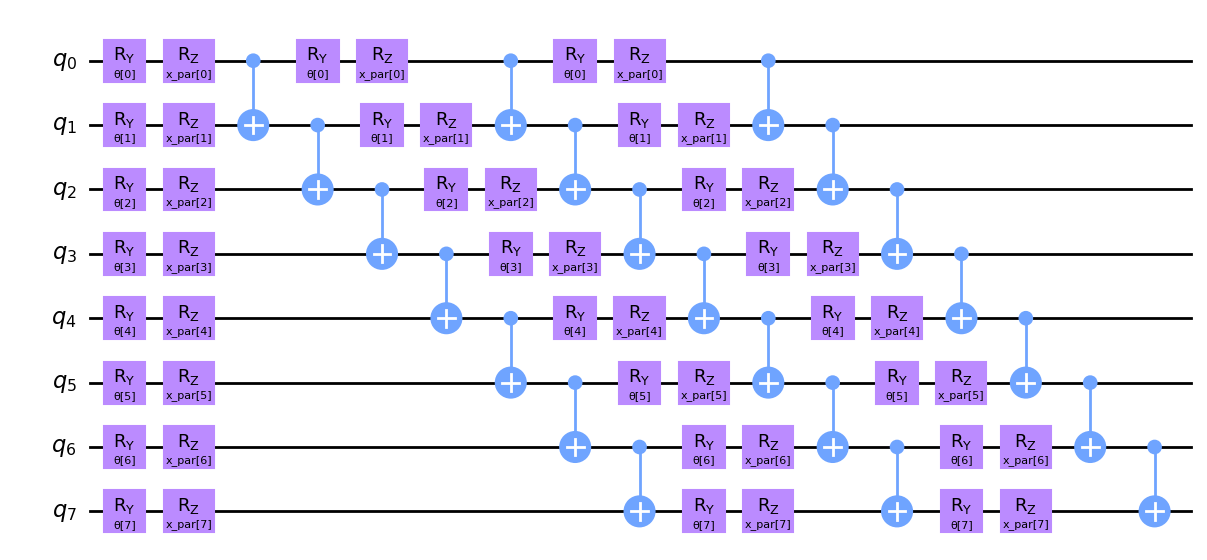

In [10]:
num_qubits = 8
qc = QuantumCircuit(num_qubits)
input_params = ParameterVector("x_par", num_qubits)
training_params = ParameterVector("θ", num_qubits)

# Add parameterized gates
for _ in range(3):
    for i, param in enumerate(training_params):
        qc.ry(param, qc.qubits[i])
    for i, param in enumerate(input_params):
        qc.rz(param, qc.qubits[i])
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)

qc.draw("mpl", style="clifford")

#### Define Quantum kernel and Optimizer

In [11]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity,
    feature_map=qc,
    training_parameters=training_params,
)

spsa_opt = SPSA(maxiter=10, learning_rate=0.02, perturbation=0.01)

#### Traine quantum kernel

In [12]:
def train_qkt_with_initial_point(initial_point, X_train, y_train, quant_kernel, loss_function, optimizer):
    """Train QuantumKernelTrainer with a specific initial point."""
    qkt = QuantumKernelTrainer(
        quantum_kernel=quant_kernel,
        loss=loss_function,
        optimizer=optimizer,
        initial_point=initial_point
    )
    results = qkt.fit(X_train, y_train)
    return results

# Parallelize Training Over Multiple Initial Points
num_initializations = 4
initial_points = [np.random.randn(num_qubits) * 0.1 for _ in range(num_initializations)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_qkt_with_initial_point)(
        initial_point,
        X_train_quantum,
        y_train_quantum,
        quant_kernel,
        SVCLoss(),
        spsa_opt
    )
    for initial_point in initial_points
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.7min finished


In [13]:
optimized_kernels = [result.quantum_kernel for result in results]

#### Save quantum kernel

In [14]:
with open('kernels/optimized_QuantumKernel.pkl', 'wb') as f:
    pickle.dump(optimized_kernels, f)

#### Load quantum kernel

In [15]:
with open('kernels/optimized_QuantumKernel.pkl', 'rb') as f:
    loaded_kernel = pickle.load(f)

#### Prepare train and test data. Tokenization

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

train_data = {'text': X_train, 'label': y_train}
test_data = {'text': X_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

#### Model Initialization and Define training arguments

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_to_id),
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,
    logging_dir="./logs",
    logging_steps=10,
    fp16=False,
    bf16=False,
    max_grad_norm=1.0,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Integrating Optimized Quantum Kernels

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
model_save_path = "./saved_models"
os.makedirs(model_save_path, exist_ok=True)

evaluation_results = []

for idx, kernel in enumerate(tqdm(optimized_kernels, desc="Processing Optimized Kernels")):
    print(f"\nProcessing Kernel {idx + 1}/{len(optimized_kernels)}")

    quantum_features = kernel.evaluate(X_train_reduced, X_train_reduced)
    quantum_features_test = kernel.evaluate(X_test_reduced, X_train_reduced)

    quantum_features_int = torch.tensor(quantum_features, dtype=torch.int64).cpu()
    quantum_features_test_int = torch.tensor(quantum_features_test, dtype=torch.int64).cpu()

    max_length = train_dataset['input_ids'].shape[1]

    def adjust_features(features, max_length):
        """Adjust features to match the max_length."""
        if features.shape[1] > max_length:
            return features[:, :max_length]
        elif features.shape[1] < max_length:
            padding = torch.zeros((features.shape[0], max_length - features.shape[1]), dtype=torch.int64)
            return torch.cat((features, padding), dim=1)
        return features

    quantum_features_int = adjust_features(quantum_features_int, max_length)
    quantum_features_test_int = adjust_features(quantum_features_test_int, max_length)

    try:
        X_train_combined = torch.cat((train_dataset['input_ids'], quantum_features_int), dim=1).cpu()
        X_test_combined = torch.cat((test_dataset['input_ids'], quantum_features_test_int), dim=1).cpu()
    except RuntimeError as e:
        print(f"Error combining features for Kernel {idx + 1}: {e}")
        continue

    extended_attention_mask_train = torch.cat(
        (train_dataset['attention_mask'], torch.ones_like(quantum_features_int, dtype=torch.int64)), dim=1
    ).cpu()
    extended_attention_mask_test = torch.cat(
        (test_dataset['attention_mask'], torch.ones_like(quantum_features_test_int, dtype=torch.int64)), dim=1
    ).cpu()

    train_dataset_combined = Dataset.from_dict({
        'input_ids': X_train_combined.tolist(),
        'attention_mask': extended_attention_mask_train.tolist(),
        'label': train_dataset['label'].tolist(),
    })

    test_dataset_combined = Dataset.from_dict({
        'input_ids': X_test_combined.tolist(),
        'attention_mask': extended_attention_mask_test.tolist(),
        'label': test_dataset['label'].tolist(),
    })

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_combined,
        eval_dataset=test_dataset_combined,
        data_collator=data_collator,
    )

    print(f"Training BERT model with Quantum Kernel {idx + 1}/{len(optimized_kernels)}...")
    try:
        trainer.train()
    except RuntimeError as e:
        print(f"Training failed for Kernel {idx + 1} due to: {e}")
        continue

    kernel_model_path = os.path.join(model_save_path, f"kernel_{idx + 1}")
    print(f"Saving trained model for Kernel {idx + 1} at {kernel_model_path}...")
    trainer.save_model(kernel_model_path)
    tokenizer.save_pretrained(kernel_model_path)

    results = trainer.evaluate()
    evaluation_results.append(results)
    print(f"Evaluation Results for Kernel {idx + 1}: {results}\n")

    torch.cuda.empty_cache()
    gc.collect()

print("Final Evaluation Results:", evaluation_results)

Processing Optimized Kernels:   0%|          | 0/4 [00:00<?, ?it/s]


Processing Kernel 1/4
Training BERT model with Quantum Kernel 1/4...


Epoch,Training Loss,Validation Loss
1,1.610300,1.609863
2,1.641900,1.611810
3,1.631100,1.613663
4,1.613000,1.610274
5,1.611400,1.611226


Saving trained model for Kernel 1 at ./saved_models/kernel_1...


Processing Optimized Kernels:  25%|██▌       | 1/4 [41:07<2:03:22, 2467.56s/it]

Evaluation Results for Kernel 1: {'eval_loss': 1.6112256050109863, 'eval_runtime': 9.1981, 'eval_samples_per_second': 21.744, 'eval_steps_per_second': 2.718, 'epoch': 5.0}


Processing Kernel 2/4
Training BERT model with Quantum Kernel 2/4...


Epoch,Training Loss,Validation Loss
1,1.596500,1.611528
2,1.634400,1.609673
3,1.621500,1.611895
4,1.608500,1.607985
5,1.611500,1.609492


Saving trained model for Kernel 2 at ./saved_models/kernel_2...


Processing Optimized Kernels:  50%|█████     | 2/4 [1:22:12<1:22:12, 2466.11s/it]

Evaluation Results for Kernel 2: {'eval_loss': 1.6094917058944702, 'eval_runtime': 9.2146, 'eval_samples_per_second': 21.705, 'eval_steps_per_second': 2.713, 'epoch': 5.0}


Processing Kernel 3/4
Training BERT model with Quantum Kernel 3/4...


Epoch,Training Loss,Validation Loss
1,1.589600,1.608770
2,1.627400,1.628832
3,1.563700,1.610018
4,1.547200,1.628995
5,1.613000,1.630930


Saving trained model for Kernel 3 at ./saved_models/kernel_3...


Processing Optimized Kernels:  75%|███████▌  | 3/4 [2:03:04<40:59, 2459.53s/it]  

Evaluation Results for Kernel 3: {'eval_loss': 1.6309295892715454, 'eval_runtime': 9.1616, 'eval_samples_per_second': 21.83, 'eval_steps_per_second': 2.729, 'epoch': 5.0}


Processing Kernel 4/4
Training BERT model with Quantum Kernel 4/4...


Epoch,Training Loss,Validation Loss
1,1.480400,1.625952
2,1.459700,1.706649
3,1.422400,1.708270
4,1.426900,1.760083
5,1.500300,1.721293


Saving trained model for Kernel 4 at ./saved_models/kernel_4...


Processing Optimized Kernels: 100%|██████████| 4/4 [2:44:10<00:00, 2462.52s/it]

Evaluation Results for Kernel 4: {'eval_loss': 1.7212926149368286, 'eval_runtime': 8.9169, 'eval_samples_per_second': 22.429, 'eval_steps_per_second': 2.804, 'epoch': 5.0}

Final Evaluation Results: [{'eval_loss': 1.6112256050109863, 'eval_runtime': 9.1981, 'eval_samples_per_second': 21.744, 'eval_steps_per_second': 2.718, 'epoch': 5.0}, {'eval_loss': 1.6094917058944702, 'eval_runtime': 9.2146, 'eval_samples_per_second': 21.705, 'eval_steps_per_second': 2.713, 'epoch': 5.0}, {'eval_loss': 1.6309295892715454, 'eval_runtime': 9.1616, 'eval_samples_per_second': 21.83, 'eval_steps_per_second': 2.729, 'epoch': 5.0}, {'eval_loss': 1.7212926149368286, 'eval_runtime': 8.9169, 'eval_samples_per_second': 22.429, 'eval_steps_per_second': 2.804, 'epoch': 5.0}]


#### Inference

In [19]:
device = torch.device("mps" if torch.has_mps else "cpu")
model.to(device)

def predict(texts, model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.to(device)

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
    encodings = {key: val.to(device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1)
    return [id_to_label[pred.item()] for pred in predictions]

#### Example Inference with the model trained on Kernel 1

In [20]:
sample_texts = ["What is quantum entanglement?", "Explain Modified Newtonian Dynamics."]
model_path = os.path.join(model_save_path, "kernel_1")
predictions = predict(sample_texts, model_path)
print("Predictions:", predictions)

Predictions: ['E', 'E']


#### TESTING

In [36]:
model_save_path = "./saved_models"
kernel_to_test_list = [1, 2, 3, 4]
max_length = 256

# Use reduced datasets for quick testing
X_test = X_test[:50]  # Reduced test prompts
X_test_reduced = X_test_reduced[:50]  # Reduced test features
X_train_reduced = X_train_reduced[:50]  # Reduced train features
y_test = y_test[:50]  # Reduced test answers

def adjust_features(features, max_length):
    """Adjust features to match the max_length."""
    if features.shape[1] > max_length:
        return features[:, :max_length]
    elif features.shape[1] < max_length:
        padding = torch.zeros((features.shape[0], max_length - features.shape[1]), dtype=torch.int64)
        return torch.cat((features, padding), dim=1)
    return features

evaluation_results = []

In [37]:

for kernel_to_test in kernel_to_test_list:
    print(f"\nEvaluating Kernel {kernel_to_test}...")

    test_model_path = os.path.join(model_save_path, f"kernel_{kernel_to_test}")
    print(f"Loading model and tokenizer from {test_model_path}...")
    reloaded_model = AutoModelForSequenceClassification.from_pretrained(test_model_path)
    reloaded_tokenizer = AutoTokenizer.from_pretrained(test_model_path)

    test_encodings = reloaded_tokenizer(
        list(X_test),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

    quantum_features_test = optimized_kernels[kernel_to_test - 1].evaluate(X_test_reduced, X_train_reduced)
    quantum_features_test_int = torch.tensor(quantum_features_test, dtype=torch.int64).cpu()
    quantum_features_test_int = adjust_features(quantum_features_test_int, max_length)

    X_test_combined = torch.cat((test_encodings['input_ids'], quantum_features_test_int), dim=1)
    attention_mask_combined = torch.cat(
        (test_encodings['attention_mask'], torch.ones_like(quantum_features_test_int, dtype=torch.int64)), dim=1
    )

    reloaded_model.eval()

    with torch.no_grad():
        outputs = reloaded_model(
            input_ids=X_test_combined,
            attention_mask=attention_mask_combined,
        )
        predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()

    predicted_labels = [id_to_label[pred] for pred in predictions]

    true_labels = [id_to_label[label] for label in y_test]

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for Kernel {kernel_to_test}: {accuracy:.4f}")

    evaluation_results.append({
        "kernel": kernel_to_test,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": classification_report(true_labels, predicted_labels, output_dict=True),
    })



Evaluating Kernel 1...
Loading model and tokenizer from ./saved_models/kernel_1...

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        11
           B       0.20      1.00      0.33        10
           C       0.00      0.00      0.00        13
           D       0.00      0.00      0.00         8
           E       0.00      0.00      0.00         8

    accuracy                           0.20        50
   macro avg       0.04      0.20      0.07        50
weighted avg       0.04      0.20      0.07        50

Confusion Matrix:
[[ 0 11  0  0  0]
 [ 0 10  0  0  0]
 [ 0 13  0  0  0]
 [ 0  8  0  0  0]
 [ 0  8  0  0  0]]
Accuracy for Kernel 1: 0.2000

Evaluating Kernel 2...
Loading model and tokenizer from ./saved_models/kernel_2...

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        11
           B       0.29      0.70      0.41    

In [23]:
# Print summary of results
print("\nFinal Evaluation Results:")
for result in evaluation_results:
    print(f"Kernel {result['kernel']} - Accuracy: {result['accuracy']:.4f}")

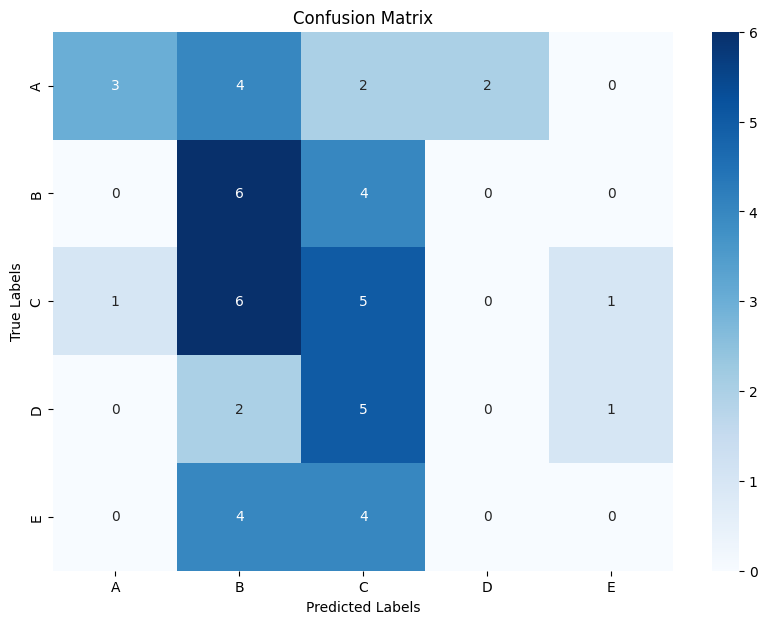

In [38]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [39]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright